# Elasticsearch Ingestion Notebook
This notebook demonstrates how to connect to Elasticsearch, create an index, and ingest movie data from a JSON file.

In [ ]:
# !pip install elasticsearch


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries
Import necessary libraries for connecting to Elasticsearch and handling JSON data.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import warnings
warnings.filterwarnings("ignore")

In [55]:


# Modified connection configuration for ES 7.x
es = Elasticsearch(
    ['http://localhost:9200'],  # Your ES host
    verify_certs=False,
    ssl_show_warn=False,
    request_timeout=30,
    api_key=None,  # Add if you have API key auth
    basic_auth=None,  # Add if you have basic auth ('user', 'password')
    # compatibility_mode=True  # This is important for older ES versions
)

# Test connection
try:
    info = es.info()
    print("Connected to Elasticsearch")
    print(f"Elasticsearch version: {info['version']['number']}")
except Exception as e:
    print(f"Connection failed: {e}")

Connected to Elasticsearch
Elasticsearch version: 7.11.2


## Initialize Elasticsearch Client
Set up the Elasticsearch client and test the connection.

In [44]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
import json
import warnings
warnings.filterwarnings("ignore")

# Initialize Elasticsearch client
es = Elasticsearch(
    ['http://localhost:9200'],
    verify_certs=False,
    ssl_show_warn=False,
    compatibility_mode=True
)

## Load Movies from JSON
Define a function to load movie data from a JSON file.

In [45]:
def load_movies_from_json(file_path):
    """Load movies from JSON file"""
    movies = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():  # Skip empty lines
                try:
                    movies.append(json.loads(line))
                except json.JSONDecodeError:
                    continue
    print("this is a repsonse from load_movies_from_json", movies[:5])
    return movies


## Create Movie Index
Define a function to create an Elasticsearch index with a specific mapping for movie data.

In [ ]:
def create_movie_index(index_name='movies'): 
    """Create movies index with mapping"""
    mapping = {
        "mappings": {
            "properties": {
                "fields": {
                    "properties": {
                        "actors": {"type": "text"},
                        "directors": {"type": "text"},
                        "genres": {"type": "text"},
                        "image_url": {"type": "text"},
                        "plot": {"type": "text"},
                        "rank": {"type": "long"},
                        "rating": {"type": "float"},
                        "release_date": {"type": "date"},
                        "running_time_secs": {"type": "long"},
                        "title": {"type": "text"},
                        "year": {"type": "long"}
                    }
                }
            }
        }
    }
    
    if not es.indices.exists(index=index_name):
        es.indices.create(index=index_name, body=mapping)
    
    print(f"Index '{index_name}' created")
    return index_name


## Process and Index Movies
Define a function to process and index movie data into Elasticsearch.

In [ ]:
def process_movies(file_path):
    """Process and index movies"""
    bulk_data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            try:
                index_line = json.loads(lines[i])
                data_line = json.loads(lines[i + 1])
                
                action = {
                    "_index": index_line["index"]["_index"],
                    "_type": "_doc",  #Use _doc for ES 7.x 
                    "_id": index_line["index"]["_id"],
                    "_source": data_line["fields"]  #Ensure correct field extraction
                }
                bulk_data.append(action)

            
            except json.JSONDecodeError:
                continue
    
    if bulk_data:
        print("Sample of first few actions:", bulk_data[:2])
        try:
            success, failed = bulk(es, bulk_data, raise_on_error=False)
            print(f"Indexed {success} documents")
            if failed:
                print(f"Failed to index {len(failed)} documents")
        except Exception as e:
            print(f"Bulk indexin g error: {e}")
    else:
        print("No data to index")

## Search Movies
Define a function to search for movies in Elasticsearch.

In [ ]:
def search_movies(query):
    """Search movies"""
    search_body = {
        "query": {
            "multi_match": {
                "query": query,
                "fields": ["fields.title", "fields.plot", "fields.genres"]
            }
        }
    }
    
    try:
        results = es.search(index="movies", body=search_body)
        for hit in results['hits']['hits']:
            movie = hit['_source']['fields']
            print(f"Title: {movie['title']}")
            print(f"Rating: {movie['rating']}")
            print(f"Genres: {', '.join(movie['genres'])}")
            print("---")
    except Exception as e:
        print(f"Search error: {e}")

## Main Execution
Define the main function to execute the entire process: connecting to Elasticsearch, creating the index, processing movies, and performing a search.

In [ ]:
def check_index_contents(index_name):
    results = es.search(index=index_name, body={"query": {"match_all": {}}}, size=2)
    print(f"Found {results['hits']['total']['value']} documents in {index_name}")
    print("Sample documents:")
    for hit in results['hits']['hits']:
        print(json.dumps(hit, indent=2))



# Main execution
def main():
    movie_file_path = 'movies_elastic.json'
    
    # Test connection
    try:
        info = es.info()
        print(f"Connected to Elasticsearch {info['version']['number']}")
    except Exception as e:
        print(f"Connection failed: {e}")
        return

    # Create index and process movies
    create_movie_index()
    process_movies(movie_file_path)
    
    # # Example search
    print("\nSearching for 'comedy' movies:")
    search_movies('comedy')

    # Add this to your main() function
    check_index_contents('movies')
    # check_index_contents('movies2')
    # check_index_contents('movies_new')

if __name__ == '__main__':
    main()

Connected to Elasticsearch 7.11.2
Index 'movies_new' created
Sample of first few actions: [{'_index': 'movies', '_type': '_doc', '_id': 1, '_source': {'directors': ['Joseph Gordon-Levitt'], 'release_date': '2013-01-18T00:00:00Z', 'rating': 7.4, 'genres': ['Comedy', 'Drama'], 'image_url': 'http://ia.media-imdb.com/images/M/MV5BMTQxNTc3NDM2MF5BMl5BanBnXkFtZTcwNzQ5NTQ3OQ@@._V1_SX400_.jpg', 'plot': 'A New Jersey guy dedicated to his family, friends, and church, develops unrealistic expectations from watching porn and works to find happiness and intimacy with his potential true love.', 'title': 'Don Jon', 'rank': 1, 'running_time_secs': 5400, 'actors': ['Joseph Gordon-Levitt', 'Scarlett Johansson', 'Julianne Moore'], 'year': 2013}}, {'_index': 'movies', '_type': '_doc', '_id': 2, '_source': {'directors': ['Ron Howard'], 'release_date': '2013-09-02T00:00:00Z', 'rating': 8.3, 'genres': ['Action', 'Biography', 'Drama', 'Sport'], 'image_url': 'http://ia.media-imdb.com/images/M/MV5BMTQyMDE0MTY0O

## Exploit the Data for some visulaization

Total movies fetched: 4849
Total number of movies: 4849
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4849 entries, 0 to 4848
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              4849 non-null   object 
 1   year               4787 non-null   float64
 2   rating             4550 non-null   float64
 3   genres             4849 non-null   object 
 4   directors          4849 non-null   object 
 5   running_time_secs  4478 non-null   float64
 6   running_time_mins  4478 non-null   float64
dtypes: float64(4), object(3)
memory usage: 265.3+ KB
None
              year       rating  running_time_secs  running_time_mins
count  4787.000000  4550.000000        4478.000000        4478.000000
mean   2001.034886     6.387108        6472.670835         107.877847
std      14.238412     1.131697        1176.453887          19.607565
min    1920.000000     1.700000        3660.000000          61.0000

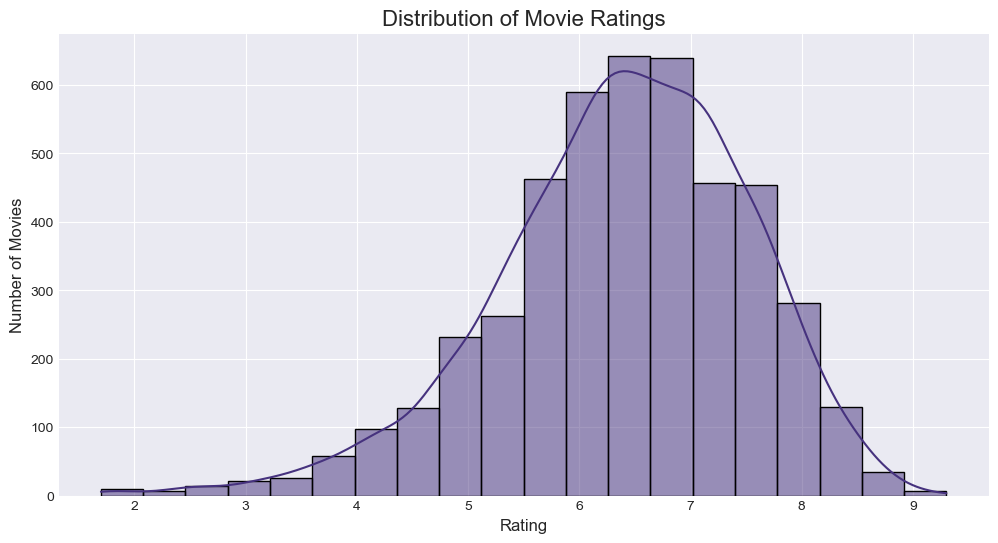

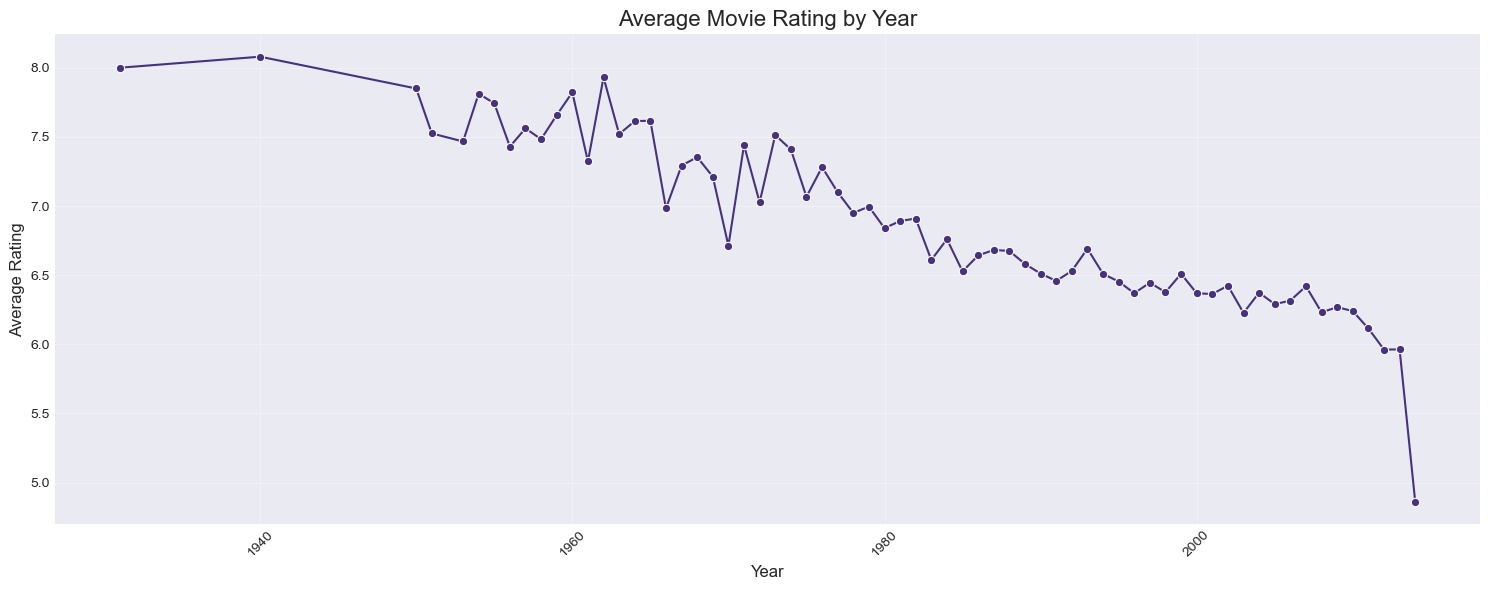

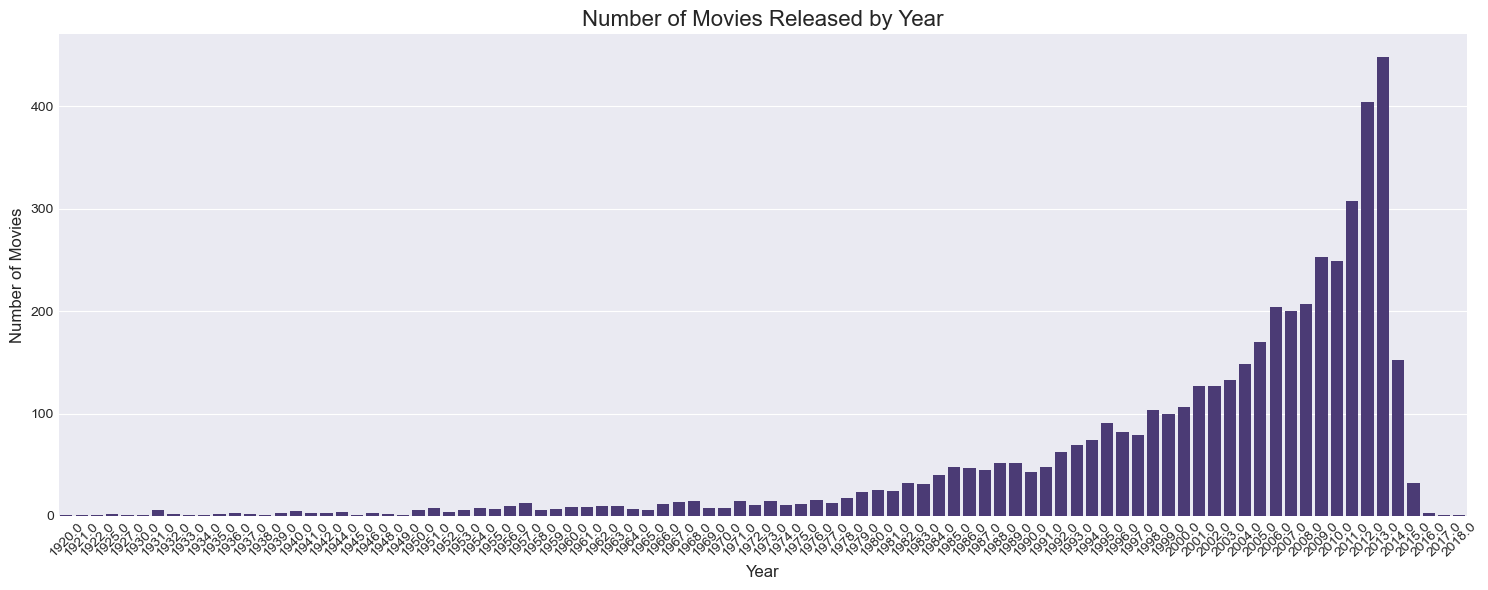

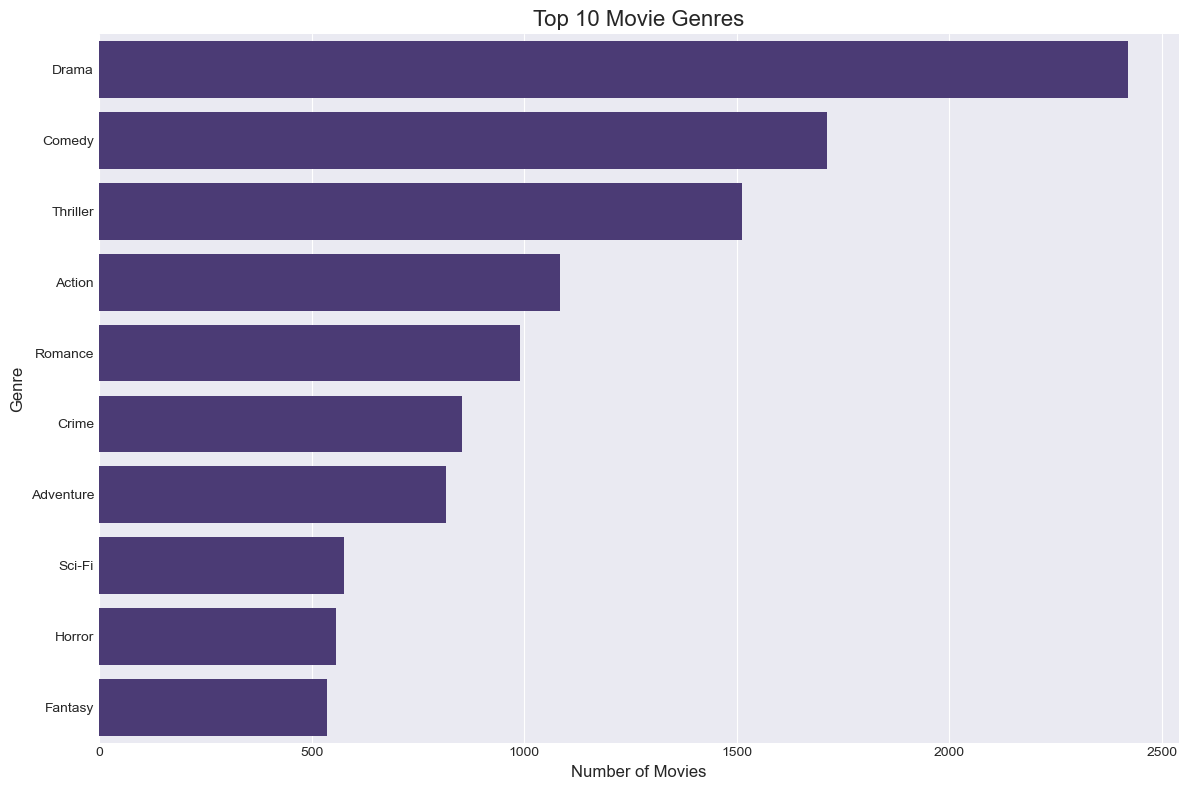

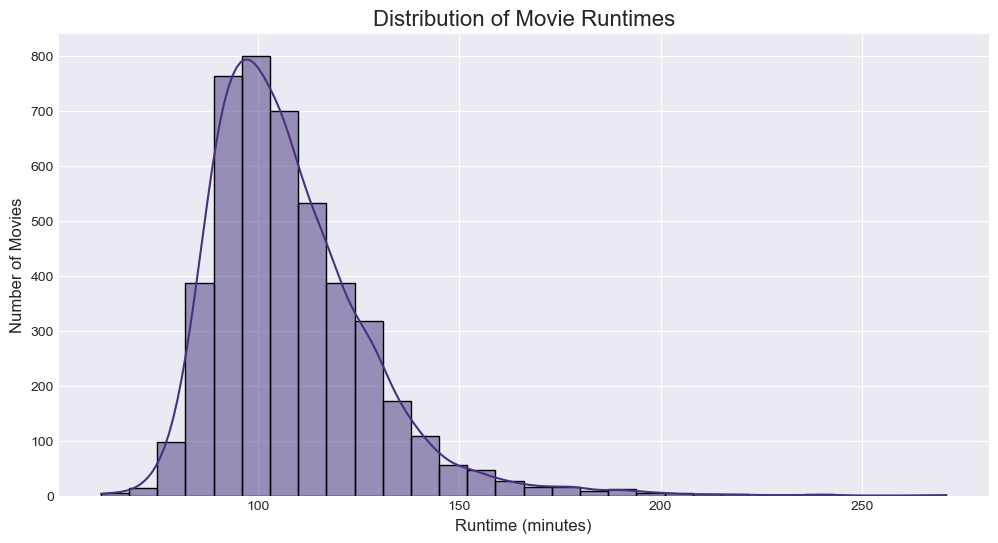

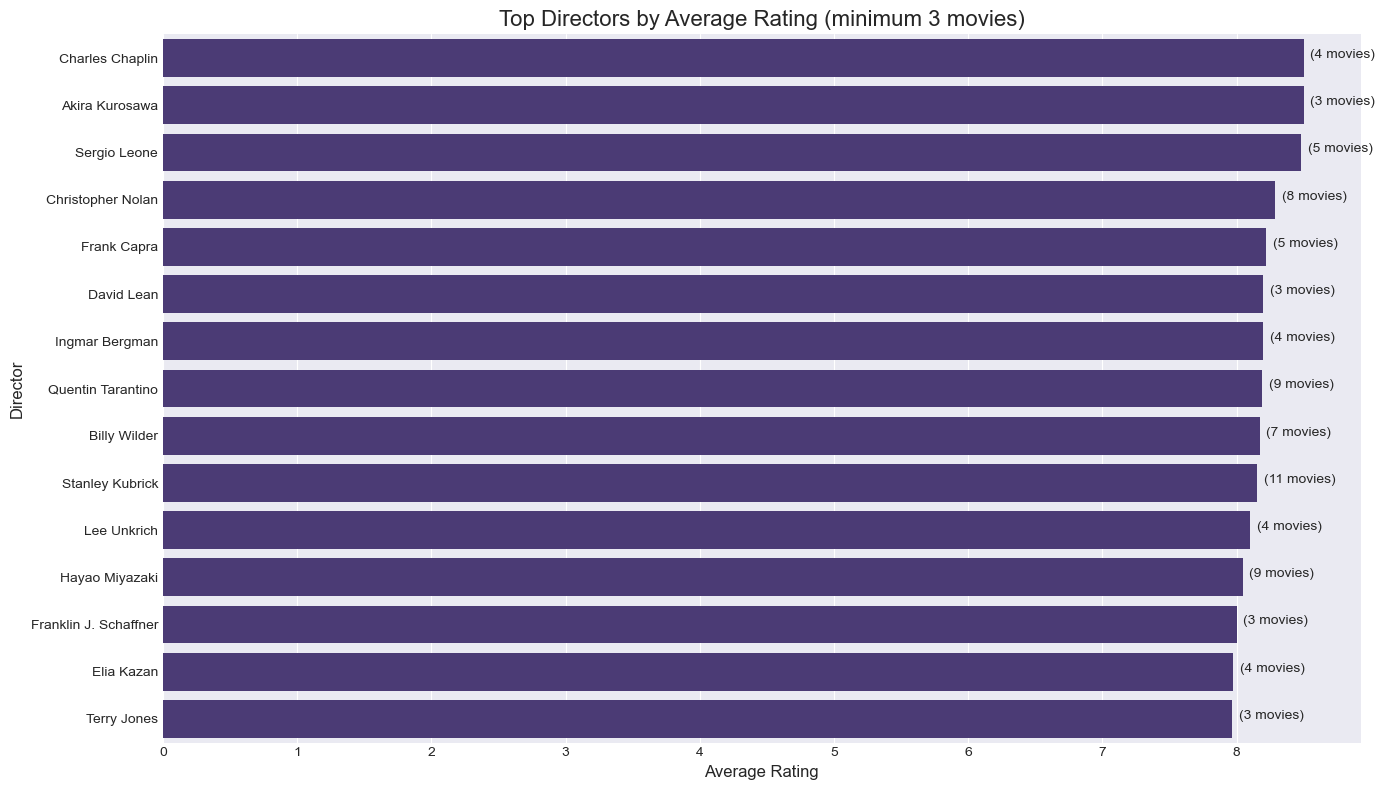

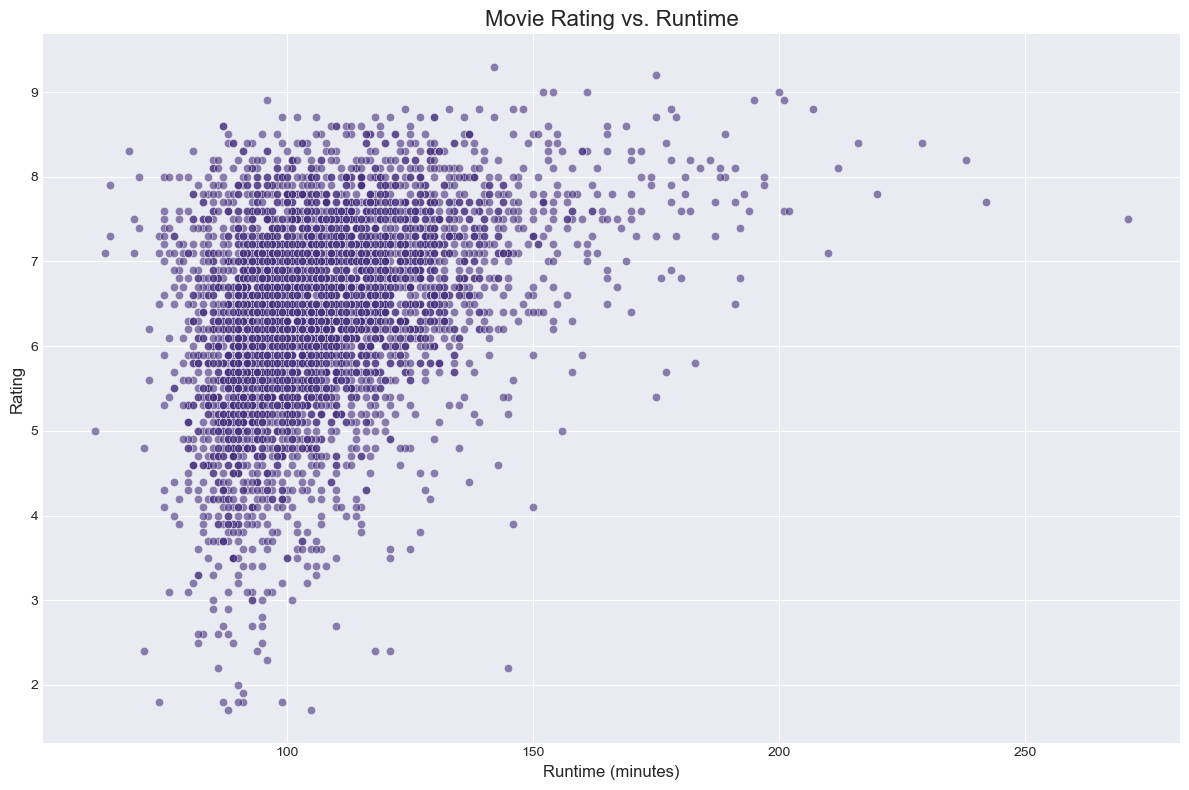

In [ ]:
# Function to fetch all movies with pagination
def fetch_all_movies(index_name='movies', size=1000):
    movies_data = []
    # Initial search
    result = es.search(
        index=index_name,
        body={
            "query": {"match_all": {}},
            "size": size,
            "sort": [{"year": {"order": "asc"}}]
        },
        scroll='2m'  # Set scroll timeout
    )
    
    # Get initial batch of results
    scroll_id = result['_scroll_id']
    hits = result['hits']['hits']
    movies_data.extend([hit['_source'] for hit in hits])
    
    # Continue scrolling until no more results
    while len(hits) > 0:
        result = es.scroll(scroll_id=scroll_id, scroll='2m')
        scroll_id = result['_scroll_id']
        hits = result['hits']['hits']
        movies_data.extend([hit['_source'] for hit in hits])
        
        # Break if no more hits
        if len(hits) == 0:
            break
    
    print(f"Total movies fetched: {len(movies_data)}")
    return movies_data

# Fetch the data
movies = fetch_all_movies()

# Convert to pandas DataFrame
def create_dataframe(movies_data):
    # Initialize empty lists to store extracted data
    titles = []
    years = []
    ratings = []
    genres_list = []
    directors_list = []
    running_times = []
    
    # Extract fields (handling different document structures)
    for movie in movies_data:
        # Handle different document structures
        if 'fields' in movie:
            movie = movie['fields']
            
        titles.append(movie.get('title', 'Unknown'))
        years.append(movie.get('year', None))
        ratings.append(movie.get('rating', None))
        
        # Handle lists
        genres = movie.get('genres', [])
        genres_list.append(genres if isinstance(genres, list) else [genres])
        
        directors = movie.get('directors', [])
        directors_list.append(directors if isinstance(directors, list) else [directors])
        
        running_times.append(movie.get('running_time_secs', None))
    
    # Create dataframe
    df = pd.DataFrame({
        'title': titles,
        'year': years,
        'rating': ratings,
        'genres': genres_list,
        'directors': directors_list,
        'running_time_secs': running_times
    })
    
    # Convert running time from seconds to minutes for better visualization
    df['running_time_mins'] = df['running_time_secs'].apply(lambda x: x/60 if x is not None else None)
    
    return df

# Create dataframe
df = create_dataframe(movies)

# Display basic information about the dataset
print(f"Total number of movies: {len(df)}")
print(df.info())
print(df.describe())


# Set a consistent style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# 1. Distribution of movie ratings
plt.figure(figsize=(12, 6))
sns.histplot(df['rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.show()

# 2. Average rating by year (for years with enough data)
year_counts = df['year'].value_counts()
valid_years = year_counts[year_counts >= 5].index.tolist()
year_ratings = df[df['year'].isin(valid_years)].groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(data=year_ratings, x='year', y='rating', marker='o')
plt.title('Average Movie Rating by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Movie count by release year
plt.figure(figsize=(15, 6))
year_counts = df['year'].value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values)
plt.title('Number of Movies Released by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Top genres analysis
def extract_all_genres(genre_lists):
    all_genres = []
    for genres in genre_lists:
        if isinstance(genres, list):
            all_genres.extend(genres)
    return all_genres

all_genres = extract_all_genres(df['genres'])
genre_counts = Counter(all_genres)
top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(12, 8))
sns.barplot(x=list(top_genres.values()), y=list(top_genres.keys()))
plt.title('Top 10 Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Runtime distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['running_time_mins'].dropna(), bins=30, kde=True)
plt.title('Distribution of Movie Runtimes', fontsize=16)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.show()

# 6. Top directors by average rating (with at least 3 movies)
def get_top_directors(df, min_movies=3):
    # Unnest directors
    directors_data = []
    for idx, row in df.iterrows():
        for director in row['directors']:
            if pd.notna(row['rating']):
                directors_data.append({
                    'director': director,
                    'rating': row['rating']
                })
    
    director_df = pd.DataFrame(directors_data)
    director_stats = director_df.groupby('director').agg(
        avg_rating=('rating', 'mean'),
        movie_count=('rating', 'count')
    ).reset_index()
    
    # Filter for directors with minimum number of movies
    top_directors = director_stats[director_stats['movie_count'] >= min_movies].sort_values(
        by='avg_rating', ascending=False
    ).head(15)
    
    return top_directors

top_directors = get_top_directors(df)

plt.figure(figsize=(14, 8))
sns.barplot(data=top_directors, x='avg_rating', y='director')
plt.title('Top Directors by Average Rating (minimum 3 movies)', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Director', fontsize=12)
for i, row in enumerate(top_directors.itertuples()):
    plt.text(row.avg_rating + 0.05, i, f"({row.movie_count} movies)")
plt.tight_layout()
plt.show()

# 7. Rating vs. Runtime scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df.dropna(subset=['rating', 'running_time_mins']), 
                x='running_time_mins', y='rating', alpha=0.6)
plt.title('Movie Rating vs. Runtime', fontsize=16)
plt.xlabel('Runtime (minutes)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.tight_layout()